In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import norm

In [2]:
data = scipy.io.loadmat("../data/v1_laminar.mat")

In [3]:
datacsd = np.array(list(data["csd"]))
timevec = data["timevec"].squeeze() 
srate = int(data["srate"])

/tmp/ipykernel_3437/3481990499.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  srate = int(data["srate"])


In [4]:
npnts = datacsd.shape[1]
ntrials = datacsd.shape[2]

chan2use = [5,6]

time2save = np.arange(-0.1, 1.14, 0.01)
times = np.zeros(len(time2save), dtype=int)
for i in range(len(time2save)):
    times[i] = np.argmin(abs(timevec - time2save[i]))

In [5]:
min_freq = 10
max_freq = 90
num_frex = 35

frex = np.linspace(min_freq, max_freq, num_frex)

wavtime = np.arange(-2, 2-1/srate, 1/srate)
half_wav = len(wavtime)//2
cycRange = [4,10]
nCycles = np.linspace(cycRange[0], cycRange[1], num_frex)

nWave = len(wavtime)
nData = npnts*ntrials
nConv = nWave+nData-1

cmwX = np.zeros((num_frex, nConv), dtype=complex)
for i in range(num_frex):
    s = nCycles[i]/(2*np.pi*frex[i])
    cmw = np.exp(1j*2*np.pi*frex[i]*wavtime) * np.exp((-wavtime**2) /(2*s**2))
    tempX = scipy.fft.fft(cmw, nConv)
    cmwX[i,:] = tempX /np.max(tempX)

In [6]:
dataX1 = scipy.fft.fft(np.reshape(datacsd[chan2use[0],:,:], -1, order="F"), nConv)
dataX2 = scipy.fft.fft(np.reshape(datacsd[chan2use[1],:,:], -1, order="F"), nConv)

tf = np.zeros((2,num_frex, len(time2save),ntrials))

for i in range(num_frex):
    as1 = scipy.fft.ifft(cmwX[i,:]*dataX1)
    as1 = as1[half_wav:-half_wav+1]
    as1 = np.reshape(as1, (npnts,ntrials), order="F")

    tf[0,i,:,:] = abs(as1[times,:])**2

    as2 = scipy.fft.ifft(cmwX[i,:]*dataX2)
    as2 = as2[half_wav:-half_wav+1]
    as2 = np.reshape(as2, (npnts,ntrials), order="F")

    tf[1,i,:,:] = abs(as2[times,:])**2


diffmap = np.squeeze(np.mean(tf[1,:,:,:], axis=2) - np.mean(tf[0,:,:,:], axis=2))

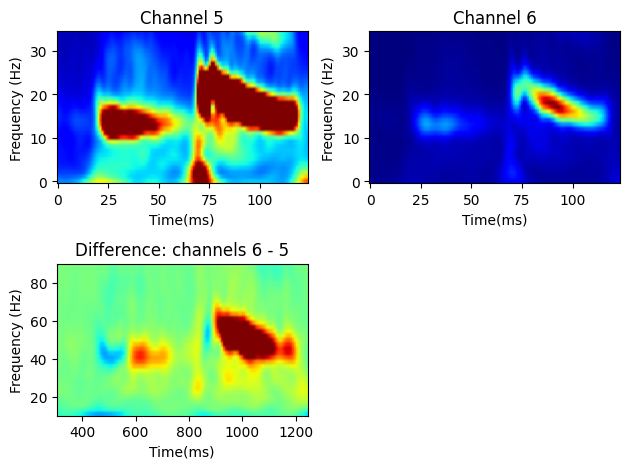

In [7]:
clim = [0,20000]
xlim=[-.1,1]

plt.subplot(221)
plt.imshow(np.mean(tf[0,:,:,:], axis=2), aspect='auto', origin='lower', vmin=clim[0], vmax=clim[1], cmap='jet')
plt.xlabel("Time(ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Channel {chan2use[0]}")

plt.subplot(222)
plt.imshow(np.mean(tf[1,:,:,:], axis=2), aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Time(ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Channel {chan2use[1]}")

plt.subplot(223)
plt.imshow(diffmap, aspect='auto', extent=[times[0], times[-1], frex[0], frex[-1]], vmin=-np.mean(clim), vmax=np.mean(clim), origin='lower', cmap='jet')
plt.xlabel("Time(ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Difference: channels {chan2use[1]} - {chan2use[0]}")

plt.tight_layout()

In [8]:
pval = 0.05

zval = abs(norm.ppf(pval))

n_permutes = 1000

permaps = np.zeros((n_permutes, num_frex, len(times)))

tf3d = np.concatenate([np.squeeze(tf[0,:,:,:]), np.squeeze(tf[1,:,:,:])], axis=2)

In [9]:
for permi in range(n_permutes):
    randorder = np.random.permutation(tf3d.shape[2])
    temp_tf3d = tf3d[:,:,randorder]

    permaps[permi,:,:] = np.squeeze(np.mean(temp_tf3d[:,:,1:ntrials], axis=2) - np.mean(temp_tf3d[:,:,ntrials:], axis=2))

In [15]:
permaps.shape

(1000, 35, 124)

In [36]:
mean_h0 = np.mean(permaps,axis=0)
std_h0 = np.std(permaps, axis=0)

zmap = (diffmap-mean_h0) / std_h0

zmap[abs(zmap)<0.05] = 0

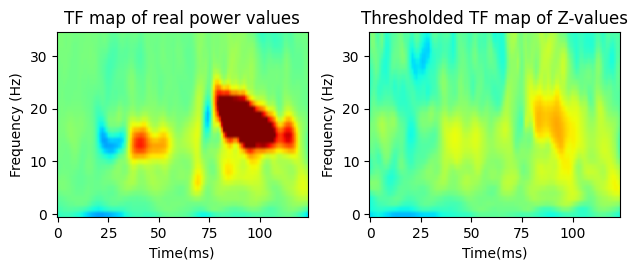

In [37]:
plt.subplot(221)
plt.imshow(diffmap, aspect='auto', origin='lower', vmin=-np.mean(clim), vmax=np.mean(clim), cmap='jet')
plt.xlabel("Time(ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"TF map of real power values")

plt.subplot(222)
plt.imshow(zmap, aspect='auto', origin='lower', vmin=-10, vmax=10,cmap='jet')
plt.xlabel("Time(ms)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Thresholded TF map of Z-values")

plt.tight_layout()